In [3]:
%pip install mne
%pip install moabb

     ---------------------------------------- 0.0/61.2 kB ? eta -:--:--
     --------------------------------- ------ 51.2/61.2 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 61.2/61.2 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.4 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 60.4/60.4 kB 809.0 kB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/133.1 kB ? eta -:--:--
     --------------------------- ----------- 92.2/133.1 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 133.1/133.1 kB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/158.4 kB ? eta -:--:--
     ----------------- --------------------- 71.7/158.4 kB 2.0 MB/s eta 0:00:0

In [25]:
import numpy as np
import moabb
from moabb.datasets import BNCI2014_004
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import MotorImagery

import mne
mne.set_log_level('error')

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


In [26]:
# Load the BCI Competition 2B dataset
dataset = BNCI2014_004()

In [27]:
subjects = [1]
original_data = dataset.get_data(subjects)

In [28]:
print(dataset.event_id)

{'left_hand': 1, 'right_hand': 2}


In [29]:
original_data

{1: {'0train': {'0': <RawArray | 7 x 604803 (2419.2 s), ~32.3 MB, data loaded>},
  '1train': {'0': <RawArray | 7 x 552452 (2209.8 s), ~29.5 MB, data loaded>},
  '2train': {'0': <RawArray | 7 x 469011 (1876.0 s), ~25.1 MB, data loaded>},
  '3test': {'0': <RawArray | 7 x 466314 (1865.3 s), ~24.9 MB, data loaded>},
  '4test': {'0': <RawArray | 7 x 474363 (1897.4 s), ~25.3 MB, data loaded>}}}

In [21]:
raw_runs = []
train_data = False
for subj in original_data:
    subject_data = original_data[subj]
    raw_runs.extend(list(subject_data['0train'].values()))
    raw_runs.extend(list(subject_data['1train'].values()))
    raw_runs.extend(list(subject_data['2train'].values()))
    raw_runs.extend(list(subject_data['3test'].values()))
    raw_runs.extend(list(subject_data['4test'].values()))


print(len(raw_runs))


KeyError: '1train'

In [22]:
raw_runs

[<RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
 <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
 <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
 <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
 <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
 <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>]

In [23]:
raw_runs[0].ch_names

['Fz',
 'FC3',
 'FC1',
 'FCz',
 'FC2',
 'FC4',
 'C5',
 'C3',
 'C1',
 'Cz',
 'C2',
 'C4',
 'C6',
 'CP3',
 'CP1',
 'CPz',
 'CP2',
 'CP4',
 'P1',
 'Pz',
 'P2',
 'POz',
 'EOG1',
 'EOG2',
 'EOG3',
 'stim']

In [24]:
mapping = {1:'left_hand', 2:'right_hand'}

# Format data:
# Set channel types
# Fetch stimulus data
for raw in raw_runs:
    ch_types = {ch: 'eeg' if ch != 'stim' else 'stim' for ch in raw.ch_names}
    raw.set_channel_types(ch_types)
    events = mne.find_events(raw, stim_channel='stim')
    
    annot_from_events = mne.annotations_from_events(events, event_desc=mapping, sfreq=raw.info['sfreq'])
    raw.set_annotations(annot_from_events)
    raw.drop_channels(['stim'])

In [9]:
# After setting annotations
print(raw.annotations)

<Annotations | 160 segments: left_hand (80), right_hand (80)>


In [10]:
raw_runs[0].ch_names

['C3', 'Cz', 'C4', 'EOG1', 'EOG2', 'EOG3']

In [11]:
motor_cortex_channels = ['C3', 'Cz', 'C4']

preprocessed_runs = raw_runs.copy()
for run in preprocessed_runs:
    run = run.resample(200)
    run = run.set_eeg_reference('average', projection=False)
    run = run.pick_channels(motor_cortex_channels)



In [12]:
raw_runs[0].ch_names

['C3', 'Cz', 'C4']

In [13]:
# Extract features for the
# alpha and beta bands

alpha_freq = {'l_freq': 8, 'h_freq': 12}
beta_freq = {'l_freq': 13, 'h_freq': 25}
alphas = []
betas = []

for i in range(len(preprocessed_runs)):
    alphas.append(preprocessed_runs[i].copy().filter(**alpha_freq))
    betas.append(preprocessed_runs[i].copy().filter(**beta_freq))

d:\OE\Tantargyak\Agyi_Jelek\PyTorch-NeuroMotor-master\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
d:\OE\Tantargyak\Agyi_Jelek\PyTorch-NeuroMotor-master\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
d:\OE\Tantargyak\Agyi_Jelek\PyTorch-NeuroMotor-master\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
d:\OE\Tantargyak\Agyi_Jelek\PyTorch-NeuroMotor-master\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
d:\OE\Tantargyak\Agyi_Jelek\PyTorch-NeuroMotor-master\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or 

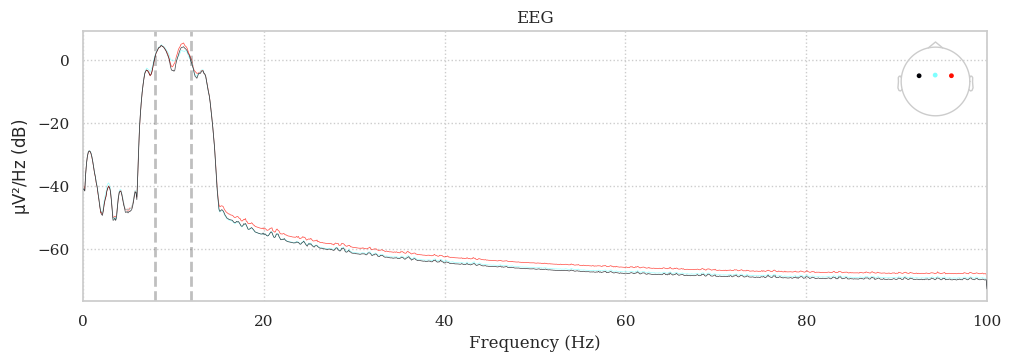

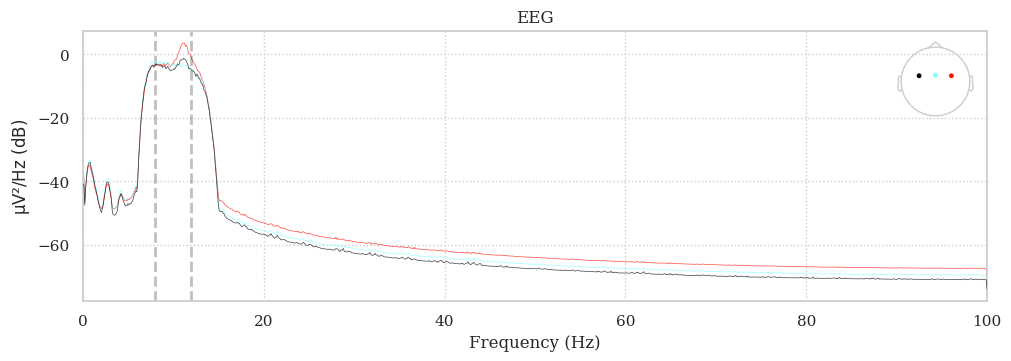

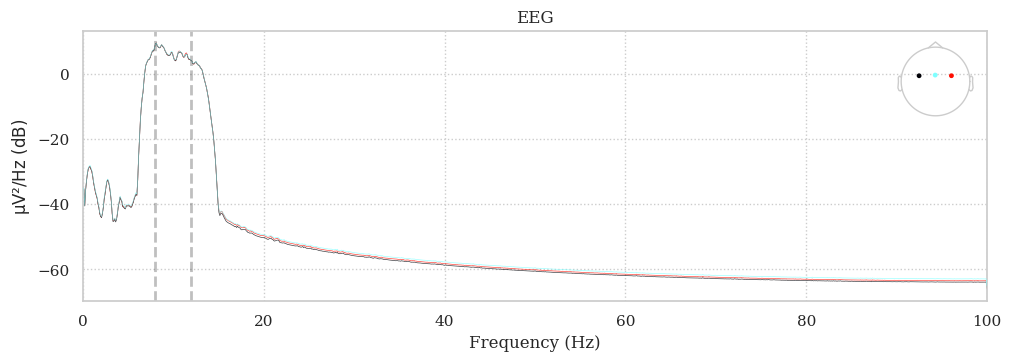

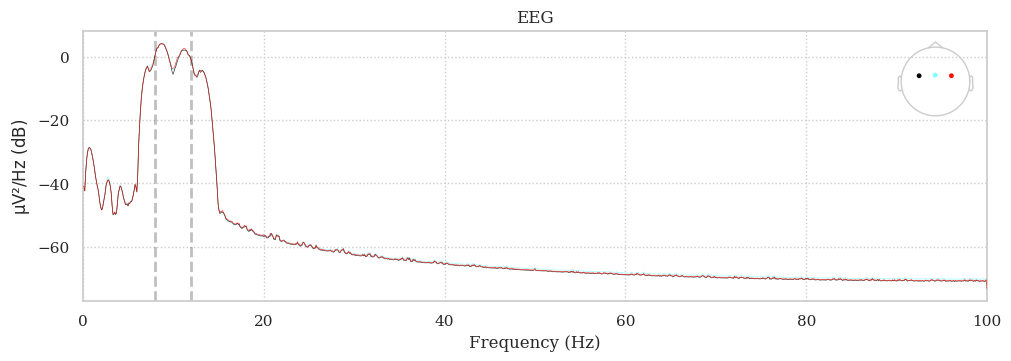

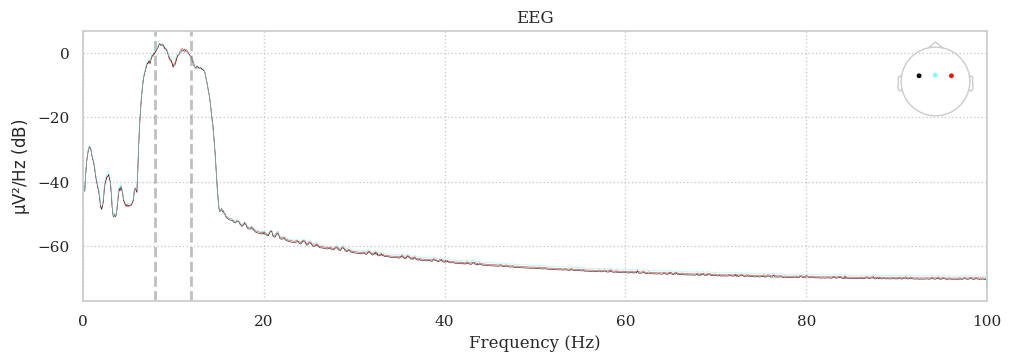

In [14]:
for alpha in alphas:
    alpha.plot_psd()

In [15]:
for beta in betas:
  beta.plot_psd()

d:\OE\Tantargyak\Agyi_Jelek\PyTorch-NeuroMotor-master\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
d:\OE\Tantargyak\Agyi_Jelek\PyTorch-NeuroMotor-master\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
d:\OE\Tantargyak\Agyi_Jelek\PyTorch-NeuroMotor-master\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
d:\OE\Tantargyak\Agyi_Jelek\PyTorch-NeuroMotor-master\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
d:\OE\Tantargyak\Agyi_Jelek\PyTorch-NeuroMotor-master\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or 

In [16]:
# Extract power features of the given frequency band

# Square data
# Split data to 0.25s long segments
# Calculate the mean of each segment
# Log transform mean values


def get_feature(data, freq = 200, segment_length = 0.25):
    # Calculate power by squaring each time sample
    eeg_data = np.square(data)


    # Define segment parameters
    segm = int(freq * segment_length)


    # Calculate mean of 0.25s segments
    eeg_data = eeg_data.reshape(eeg_data.shape[0],-1, segm)
    eeg_data = np.mean(eeg_data,axis=-1)


    # Log transform the data
    eeg_data = np.log(eeg_data)
    return eeg_data

In [17]:
sfreq = raw_runs[0].info['sfreq']
segment_length = 0.25

tmin = 2
tmax = 6



mapping = {1:'left_hand', 2:'right_hand'}
train_data = {'left_hand': [], 'right_hand': []}


for i in range(len(preprocessed_runs)):
    # Get events from annotations
    events, _ = mne.events_from_annotations(preprocessed_runs[i])

    # Iterate through events
    for trigger in events:
        t = trigger[0]
        event_code = trigger[-1]

        # Extract the relevant data segments
        start = int(t + (sfreq * tmin))
        end = int(t + (sfreq * tmax))

        alpha_data = alphas[i].get_data()[...,start:end]
        beta_data = betas[i].get_data()[...,start:end]

        # feature extraction
        alpha_features = get_feature(alpha_data)
        beta_features = get_feature(beta_data)


        # Format data
        alpha_features = alpha_features.flatten()
        beta_features = beta_features.flatten()
        features = np.concatenate((alpha_features, beta_features), axis=0)
        train_data[mapping[trigger[-1]]].append(features)



for data in train_data:
    train_data[data] = np.array(train_data[data], dtype=np.float32)
    print(data)
    print(train_data[data].shape)

left_hand
(360, 96)
right_hand
(360, 96)


In [18]:
# Get features and labels of the 2  hand classes
X = np.concatenate((train_data['left_hand'], train_data['right_hand']), axis=0)
y = np.concatenate((np.ones(train_data['left_hand'].shape[0]), np.zeros(train_data['right_hand'].shape[0])), axis=0)


In [19]:
X.shape

(720, 96)

In [20]:
X

array([[-27.75186 , -28.72332 , -26.322247, ..., -25.451561, -25.161964,
        -25.751072],
       [-27.976921, -26.561949, -27.746712, ..., -26.157381, -26.08493 ,
        -25.939924],
       [-27.647467, -26.82971 , -26.827091, ..., -25.494173, -24.989286,
        -26.258324],
       ...,
       [-26.329716, -26.72796 , -27.716286, ..., -26.76885 , -26.08996 ,
        -26.362236],
       [-27.831598, -26.890413, -28.044487, ..., -26.41363 , -26.280107,
        -25.850355],
       [-28.061335, -28.249575, -27.32293 , ..., -25.470951, -25.780012,
        -25.160961]], dtype=float32)

In [21]:
y.shape

(720,)

In [22]:
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.